In [1]:
'''
Authors: Daniel M. Low
License: Apache 2.0

'''

import os
import sys
import numpy as np
import pandas as pd
import json
from collections import Counter
from pprint import pprint
import requests
import time
from datetime import datetime, date, timedelta
import string
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import plotly.express as px
from plotly import graph_objs as go
from sklearn import preprocessing
from statsmodels.stats.multitest import multipletests
# sys.path.append('./../../catpro')
# from catpro.preprocessing_text.extract_features import liwc, words, punctuation_count, sentiment_analysis, count_words, tfidf

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



import plotly.express as px
import plotly.graph_objs as go
import chart_studio.plotly as py

In [2]:
def histogram(y):
    sns.set(style='white', rc={'figure.figsize':(10,8)}, palette = "coolwarm", font_scale =1)
    labels, values = zip(*Counter(y).items())
    labels, values  = zip(*sorted(zip(labels, values )))
    labels = [int(n) for n in labels]


    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels, rotation=90)
    plt.show()
    return


In [3]:
# input y variable across time


def plot_across_time(subreddits, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        if y_col == 'total_posts':
            y = total_posts.copy()
        else:
            y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
            try: x.remove(np.nan)
            except: pass
            x.sort()
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [4]:

def boxplot_across_time(subreddit, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [15]:
def timeseries_summary(input_dir, subreddit = 'personalfinance', pre_or_post = 'post', 
                       timestep = 3, metric='mean',weigh_by_Nwords = True,filter_days = False, zscore_slope = True):
    # Merge different types of features     
    df = pd.read_csv(input_dir+'feature_extraction/{}_{}_features.csv'.format(subreddit,pre_or_post))
#     df_phrases = pd.read_csv(input_dir+'phrases_features/{}_{}_phrases.csv'.format(subreddit,pre_or_post))

    # assert df_features.shape[0] == df_phrases.shape[0]
    # assert list(df_features.author) == list(df_phrases.author)
#     df = df_features.merge(df_phrases,how='inner' ) #inner is default, will elimante rows not shared on shared cols (post, author, etc, date)
    # https://stackoverflow.com/questions/53645882/pandas-merging-101
    features = list(df.columns)
    features = [n for n in features if n not in ['subreddit','author','date','post']]
    
    # Weigh value by amount of words in posts (if not amount of words will confound patterns in other variables)     
    if weigh_by_Nwords:
        # weight these variables by n_words
        weigh = features.copy()
        [weigh.remove(n) for n in ['n_chars', 'n_sents', 'n_words','sent_neg', 'sent_neu', 'sent_pos','sent_compound', 'automated_readability_index', 'coleman_liau_index',
               'flesch_kincaid_grade_level', 'flesch_reading_ease', 'gulpease_index',
               'lix', 'wiener_sachtextformel', 'gunning_fog_index', 'smog_index']]
        df[weigh] = df[weigh].div(df['n_words'].values, axis=0)

    
    # Group value by timestep     
    days = np.unique(df.date)
    if filter_days:
        for day in filter_days:
            days = [n for n in days if day not in n]
    days_timestep = days[::timestep]
    X = []
    y = []
    for i in range(0,len(days),timestep):
      days_week = days[i:i+timestep]
      df_week = df[df.date.isin(days_week)]
      df_week_feature_cols = df_week[features].values
      df_week_y = list(df_week.subreddit)
      X.append(df_week_feature_cols)
      y.append(df_week_y)

    X = np.array(X)
    y = np.array(y)
    
    # Take summary stat metric by timestep     
    summary = []
    for timestep in X:
        n_posts = timestep.shape[0] 
        if metric == 'mean':
            summary_timestep = timestep.mean(axis=0)
            summary_timestep = np.append(summary_timestep, n_posts)
        summary.append(summary_timestep)

    summary = pd.DataFrame(summary)
    summary = summary.apply(zscore)
    summary = summary.T
    summary.columns = days_timestep
    summary.index = features+['n_posts']



    # add slope and p-value
    slopes = []
    p_values = []
    significances = []
    r2 = []
    for feature in features+['n_posts']:
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(summary.T.index)), summary.T[feature])
        slopes.append(slope)
        p_values.append(p_value)
        r2.append(r_value**2)
        corrected_alpha = 0.05     # corrected_alpha = 0.05/len(features)
        if p_value <= corrected_alpha:
            significances.append(1)
        else:
            significances.append(-1)
    
    if zscore_slope:
        summary['slope'] = stats.zscore(slopes)
        summary['p_value'] = stats.zscore(p_values)
        summary['sign'] = stats.zscore(significances)
        summary['r2'] = stats.zscore(r2)
    else:
        summary['slope'] = slopes
        summary['p_value'] = p_values
        summary['sign'] = significances
        summary['r2'] = r2
        
    return summary
    

In [ ]:
# # Run this cell to be able to mount GDrive and attach it to the colab so that we can save json outputs
# from google.colab import drive
# drive.mount('/content/drive')
# output_dir = '/content/drive/My Drive/reddit_json/'

## Load subreddits and order them 

In [46]:
# Load data
input_dir = './../../datum/reddit/input/'
subreddits = os.listdir(input_dir+'feature_extraction')
pre_or_post = 'post' #post is 01-05 2020, pre is all of 2019
subreddits = [n.replace(f'_{pre_or_post}_features.csv','') for n in subreddits if f'{pre_or_post}' in n]


In [47]:
# Remove small or redudant subreddits 
a = [subreddits.remove(n) for n in ['mentalillness', 'meditation']]
print('all subreddits: ',subreddits)

all subreddits:  ['addiction', 'guns', 'socialanxiety', 'schizophrenia', 'healthanxiety', 'suicidewatch', 'EDAnonymous', 'mentalhealth', 'COVID19_support', 'teaching', 'fitness', 'personalfinance', 'bipolarreddit', 'adhd', 'conspiracy', 'autism', 'alcoholism', 'bpd', 'ptsd', 'divorce', 'legaladvice', 'jokes', 'mindfulness', 'anxiety', 'depression', 'parenting', 'relationships', 'lonely']


In [131]:
#     reorder by related subreddits
subreddits = [
     'COVID19_support',
'mentalhealth',
    'anxiety',
     'socialanxiety',
     'healthanxiety',
         'autism',
 'adhd',  
     'ptsd',
     'lonely',
     'depression',
 'suicidewatch',    
     'bipolarreddit',
     'bpd',
     'schizophrenia',
    'addiction',
     'alcoholism',
 'EDAnonymous',
 'personalfinance',
     'conspiracy',
     'guns',
 'legaladvice',    
    'divorce',
 'relationships',
    'parenting',
    'teaching',
 'mindfulness',
 'fitness',
 'jokes'
]

subreddits_mental_health = [
     'anxiety',
     'socialanxiety',
     'healthanxiety',
         'autism',
 'adhd',  
     'ptsd',
     'lonely',
     'depression',
 'suicidewatch',    
     'bipolarreddit',
     'bpd',
    'addiction',
     'alcoholism',
 'EDAnonymous',
 'schizophrenia']
    

## How many times is COVID19mentioned and when?


In [20]:
covid_mentions = []
for sr in subreddits_mental_health:
    print(sr)
    summary = timeseries_summary(input_dir, subreddit = sr, pre_or_post = 'post', 
                           timestep = 2, metric='mean',weigh_by_Nwords = True, filter_days = False,zscore_slope=False)
    sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
    # for variable in keep:
    for variable in ['covid19_total']:
        print('====={}===='.format(variable))
        x_name = summary.columns[:-4].values
        x_name = [n.replace('2020/','') for n in x_name]
        x = range(len(x_name))
        y = summary.T[variable][:-4].values
        covid_mentions.append([sr, y, x_name, x])

        
      


addiction
=====covid19_total====
EDAnonymous
=====covid19_total====
adhd
=====covid19_total====
autism
=====covid19_total====
alcoholism
=====covid19_total====
bipolarreddit
=====covid19_total====
depression
=====covid19_total====
anxiety
=====covid19_total====
healthanxiety
=====covid19_total====
lonely
=====covid19_total====
schizophrenia
=====covid19_total====
socialanxiety
=====covid19_total====
suicidewatch
=====covid19_total====


In [21]:
covid_mean = [n[1] for n in covid_mentions]
covid_mean = np.mean(covid_mean, axis=0)

In [22]:
# Load confirmed COVID19 cases from World in Data dataset
total_cases = pd.read_csv('./data/total_cases.csv')
# Select only these days
days = ['2020-'+n.replace('/', '-') for n in x_name]
total_cases = total_cases[total_cases.date.isin(days)]
usa = total_cases['United States'].values
world = total_cases['World'].values
china = total_cases['China'].values

In [23]:
usa = [int(str(n).replace('0','1')) for n in usa]
china = [int(str(n).replace('0','1')) for n in china]

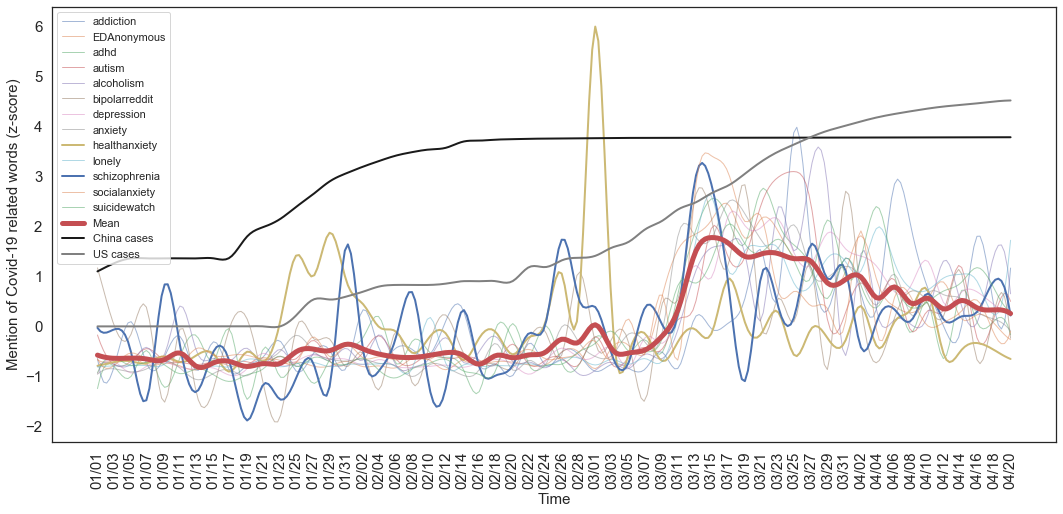

In [302]:
from scipy.interpolate import make_interp_spline, BSpline

sns.set(style='white', rc={'figure.figsize':(18,8)}, font_scale =1)

for sr, y, x_name, x in covid_mentions:
    xnew = np.linspace(np.min(x), np.max(x), 300)  
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    alpha=0.5
    linewidth = 1
    if sr in ['healthanxiety', 'schizophrenia']:
        alpha=1
        linewidth = 2
#     plt.figure()
    plt.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth)
#     plt.plot(x,y, label=sr)
#     plt.show()
#     plt.figure()

# Plot Mean
spl = make_interp_spline(x, covid_mean, k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew,power_smooth, label='Mean', alpha=1, linewidth=5.0)
# World 
spl = make_interp_spline(x, np.log(china), k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew,power_smooth/3, label='China cases', alpha=1, linewidth=2.0, c='k')
# usa
spl = make_interp_spline(x, np.log(usa), k=3)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew,power_smooth/3, label='US cases', alpha=1, linewidth=2.0, c='gray')
# Plot the rest
plt.legend()
plt.ylabel('Mention of Covid-19 related words (z-score)', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.xticks(ticks=x, labels=x_name, rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./data/covid_mentions_covid_cases.png', dpi=400)
plt.show()


# Plot raw data for a single feature

r2: 0.00044314941210183816 p-value:  3.9826074809113194e-08


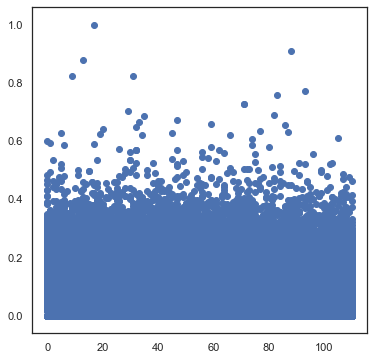

In [85]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)

# Load a single subreddit
subreddit = 'depression'
df = pd.read_csv(input_dir+'feature_extraction/{}_{}_features.csv'.format(subreddit,pre_or_post))

feature='sent_pos'
x = df.date.values
le = preprocessing.LabelEncoder()
y = df[feature].values
x = le.fit_transform(x)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.scatter(x,y)
print('r2:',r_value**2, 'p-value: ',p_value)


r2: 0.18106204448434088 p-value:  3.230680442427489e-06


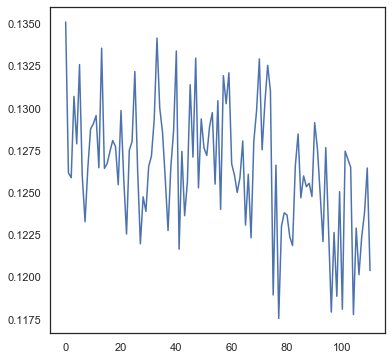

In [86]:
# Plot averaged data
df_regr = pd.DataFrame({'x':x,'y':y})
df_regr = df_regr.groupby(['x']).mean() 
df_regr.shape[0]
assert df_regr.shape[0] == len(np.unique(x))

x = df_regr.index.values
y = df_regr['y'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,y)
print('r2:',r_value**2, 'p-value: ',p_value)


In [11]:
# Filter features
keep = [
    'n_posts', 'n_words',     'n_chars', 'punctuation',  'n_sents', 
    #     word_type
    'n_unique_words', 'n_long_words',        'n_syllables',   'n_monosyllable_words', 'n_polysyllable_words', 
    
#     functionals    
    'liwc_total_functional', 'liwc_impersonal_pronouns', 'liwc_total_pronouns', 'liwc_personal_pronouns',
'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 
       'liwc_articles_article', 
#     POS
    'liwc_common_verbs',
       'liwc_auxiliary_verbs', 'liwc_past_tense', 'liwc_present_tense', 'liwc_future_tense',
       'liwc_adverbs', 'liwc_prepositions', 'liwc_conjunctions', 'liwc_negations',    'liwc_assent',
       'liwc_quantifiers', 'liwc_numbers', 
    'liwc_nonfluencies', 'liwc_fillers',
    
#     readability
    'flesch_kincaid_grade_level', 'lix',
'automated_readability_index',
       'coleman_liau_index',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index',
       'smog_index', 'wiener_sachtextformel',     

#    Sentiment 
    'sent_neg', 'sent_neu', 'sent_pos',
       'sent_compound', 
    'liwc_affective_processes',
       'liwc_positive_emotion', 'liwc_negative_emotion', 'liwc_anxiety', 'liwc_anger','liwc_swear_words', 
       'liwc_sadness',
# Existential / death    
    'liwc_religion', 
    'liwc_death', 'guns_total','substance_use_total', 'suicidality_total',
# Cognitive    
    'liwc_cognitive', 'liwc_insight', 'liwc_causation', 'liwc_discrepancy',
       'liwc_tentative', 'liwc_certainty', 'liwc_inhibition', 'liwc_inclusive', 'liwc_exclusive',
       'liwc_perceptual_processes', 'liwc_see', 'liwc_hear', 'liwc_feel', 
# Biological
    'liwc_biological',
'liwc_ingestion', 'liwc_relativity', 'liwc_motion','liwc_body', 'liwc_health', 'liwc_sexual', 
    # Work, economic stress, leisure
    'liwc_work',     'liwc_leisure',  'economic_stress_total', 'liwc_money','liwc_time','liwc_achievement',
    # Social and home and isolation
    'liwc_social_processes','liwc_home',         
    'domestic_stress_total','liwc_space',    
       'liwc_family', 'liwc_friends', 'liwc_humans', 'isolation_total',
#     covid
        'covid19_total',  
    
]





## Plot mean values and regression stats

In [16]:
subreddit = 'personalfinance'
summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = 'post', 
                       timestep = 2, metric='mean',weigh_by_Nwords = True, filter_days = False,zscore_slope=False)





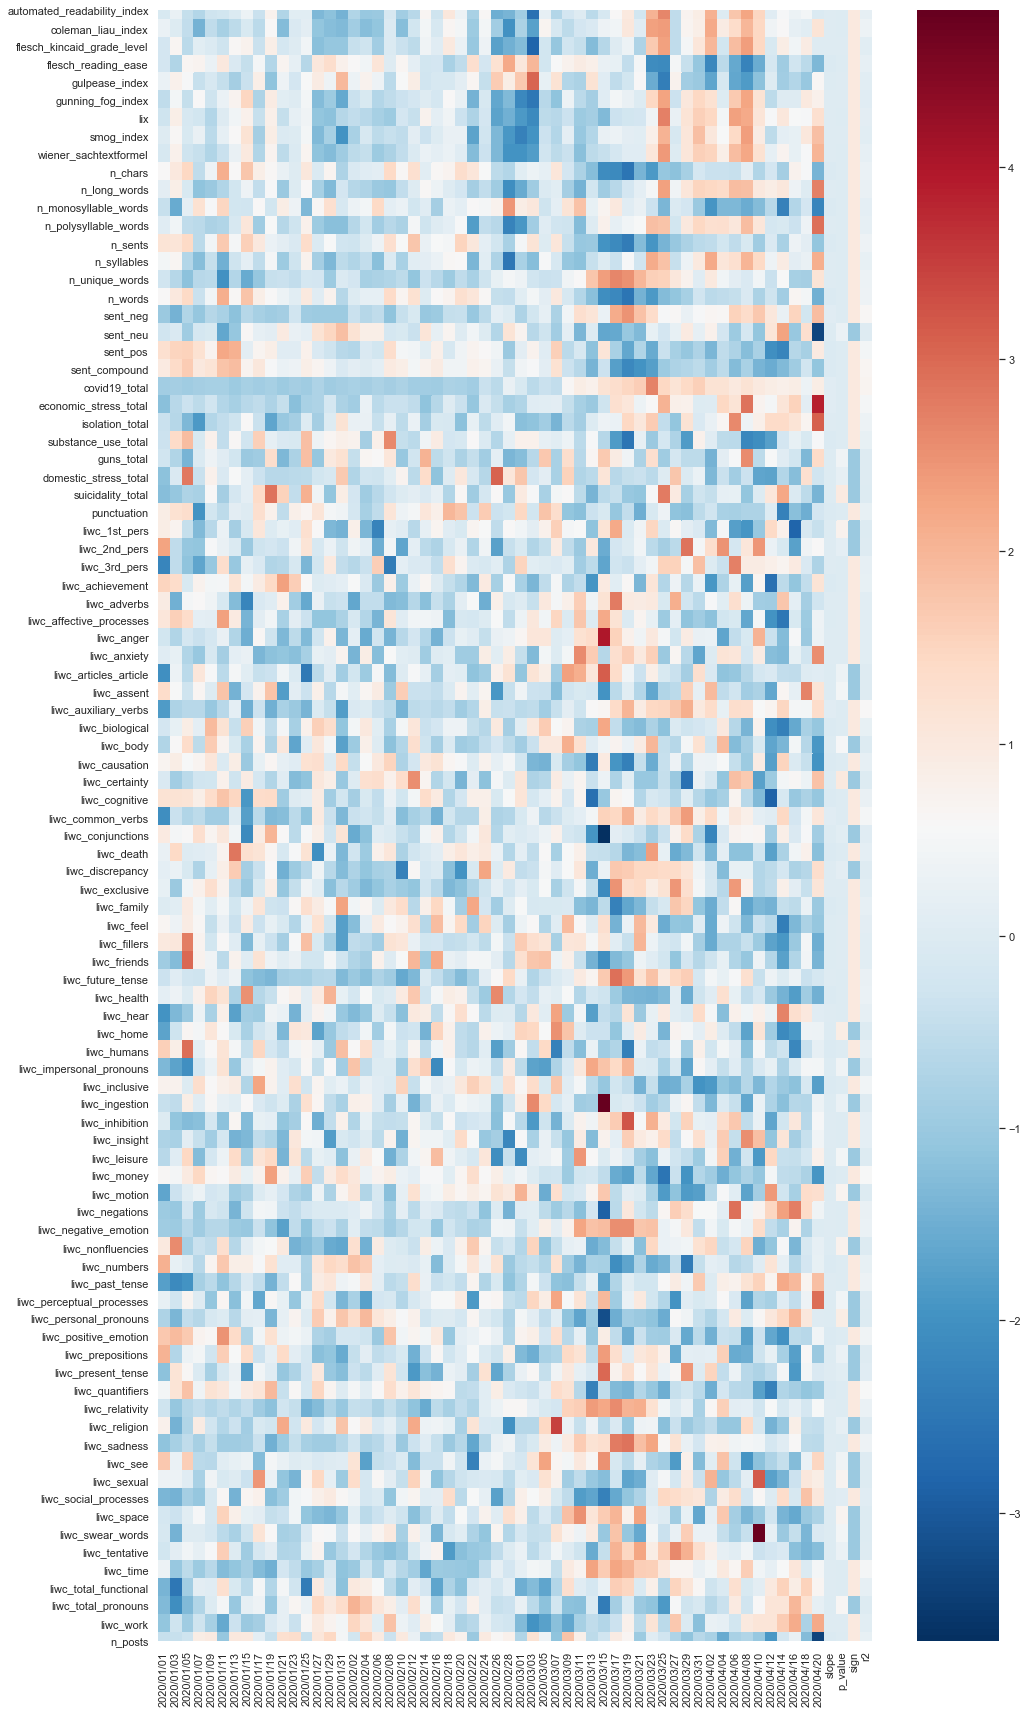

In [17]:
# Plot
sns.set(style='white', rc={'figure.figsize':(16,30)}, font_scale =1)
sns.heatmap(summary, cmap = 'RdBu_r')

In [ ]:
# Interpret: Look at words in LIWC features
liwc = pd.read_csv('./../../datum/util_nlp/liwc_english_dictionary/categories.txt', sep=',').iloc[:,1].values

liwc_words = np.load('./../../datum/util_nlp/liwc_english_dictionary/liwc.npy',allow_pickle=True).item()

liwc_words['motion']

## See some features in detail and plot regression line in color for examples


=====sent_pos====


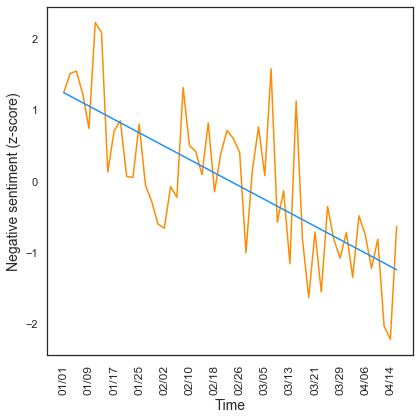

In [18]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
# for variable in keep:
for variable in ['sent_pos']:
    print('\n====={}===='.format(variable))
    x_name = summary.columns[:-6].values
    x_name = [n.replace('2020/','') for n in x_name]
    x = range(len(x_name))
    y = summary.T[variable][:-6].values
    plt.plot(x_name,y ,color='darkorange')
    plt.title('')
    plt.ylabel('Negative sentiment (z-score)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(np.arange(min(x), max(x)+1, 4),rotation=90, fontsize = 12)
#     plt.xticks(rotation=90)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='dodgerblue')
    plt.tight_layout()
    plt.savefig('./data/trend_example_down_neg_sent.png', dpi=400)
    plt.show()



=====isolation_total====


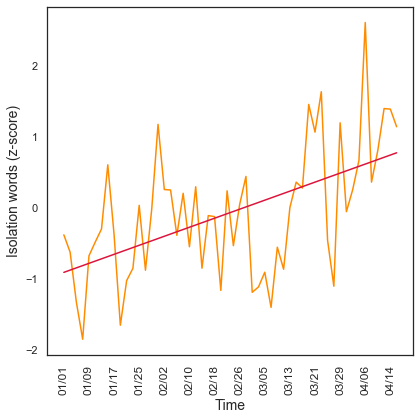

In [19]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
# for variable in keep:
for variable in ['isolation_total']:
    print('\n====={}===='.format(variable))
    x_name = summary.columns[:-6].values
    x_name = [n.replace('2020/','') for n in x_name]
    x = range(len(x_name))
    y = summary.T[variable][:-6].values
    plt.plot(x_name,y ,color='darkorange')
    plt.title('')
    plt.ylabel('Isolation words (z-score)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(np.arange(min(x), max(x)+1, 4),rotation=90, fontsize = 12)
#     plt.xticks(rotation=90)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='crimson')
    plt.tight_layout()
    plt.savefig('./data/trend_example_up_isolation.png', dpi=400)
    plt.show()


## Main summary figure: slope*r^2 for all features and all subreddits

In [88]:
from statsmodels.stats.multitest import multipletests
import json
from matplotlib.colors import DivergingNorm

In [136]:
def main_table(subreddits, features, timestep =2, pre_or_post = 'post', add_subreddits_to_features=True):
    # If using older data, than we want to filter months to match 2020 data
    if pre_or_post == 'pre':
        filter_days = ['2018/']+ ['2019/04/'+str(n).zfill(2) for n in range(21,31) ]+['2019/'+str(n).zfill(2) for n in range(5,13) ]
    else:
        filter_days = False
    
    slope_all = []
    r2_all = []
    p_value_all = []

    print('loading...')
    for sr in subreddits:
        print(sr)
        summary_sr = timeseries_summary(input_dir, subreddit = sr, pre_or_post = pre_or_post, 
                           timestep = timestep, metric='mean',weigh_by_Nwords = True, zscore_slope =False,filter_days=filter_days)
        summary_sr_slope = summary_sr[['slope']]
        slope_all.append(summary_sr_slope)
        r2_all.append(summary_sr[['r2']]) 
        p_value_all.append(summary_sr[['p_value']])
    
    # Build DF from list of DFs
    df_slope = pd.concat(slope_all, axis=1) 
    df_r2 = pd.concat(r2_all, axis=1) 
    df_p_value = pd.concat(p_value_all, axis=1)

    # Add col name
    df_slope.columns = subreddits
    df_r2.columns = subreddits
    df_p_value.columns = subreddits

    # Filter features
    print('features before filtering: ',df_slope.shape)
    df_slope = df_slope.T[keep].T
    df_r2 = df_r2.T[keep].T
    df_p_value = df_p_value.T[keep].T
    print('features after filtering: ',df_slope.shape)

    # slope * r^2 
    df_slope_r2 = df_slope*df_r2

    # Multiple comparison correction
    pvals= df_p_value.values.flatten() 
    reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

    # Create mask with significant results
    reject_opp = np.array([not c for c in reject]) #inverse mask of booleans
    df_shape = df_p_value.shape # reshape to this shape
    reject_df = pd.DataFrame(reject_opp.reshape(df_shape))
    reject_df.columns = df_slope_r2.columns
    reject_df.index = df_slope_r2.index
    print('Significant results: ',np.sum(reject)/len(reject))
    
    if add_subreddits_to_features:
    # Y-AXIS: Add mental health subreddits that most use each feature for classification (computed only using highest coefficients (top 50%) )
        with open('./../../datum/reddit/output/binary6_model0/main_sr_per_feature.json', 'r') as fp:
            max_features = json.load(fp)

        df_index = df_slope_r2.index 
        # insert into y-axis
        df_index_new = []
        for i in df_index:
            sr = max_features.get(i)
            if sr==None:
                df_index_new.append(''+i)
            else:
                df_index_new.append('({})   '.format(sr)+i)

        df_slope_r2.index = df_index_new
        reject_df.index = df_index_new
    
    return df_slope_r2, reject_df


    

In [114]:
pre_or_post = 'post'
df_slope_r2, reject_df = main_table(subreddits, keep, pre_or_post = pre_or_post, add_subreddits_to_features=True)

loading...
COVID19_support
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
mindfulness
fitness
jokes
features before filtering:  (92, 28)
features after filtering:  (92, 28)
Significant results:  0.18866459627329193


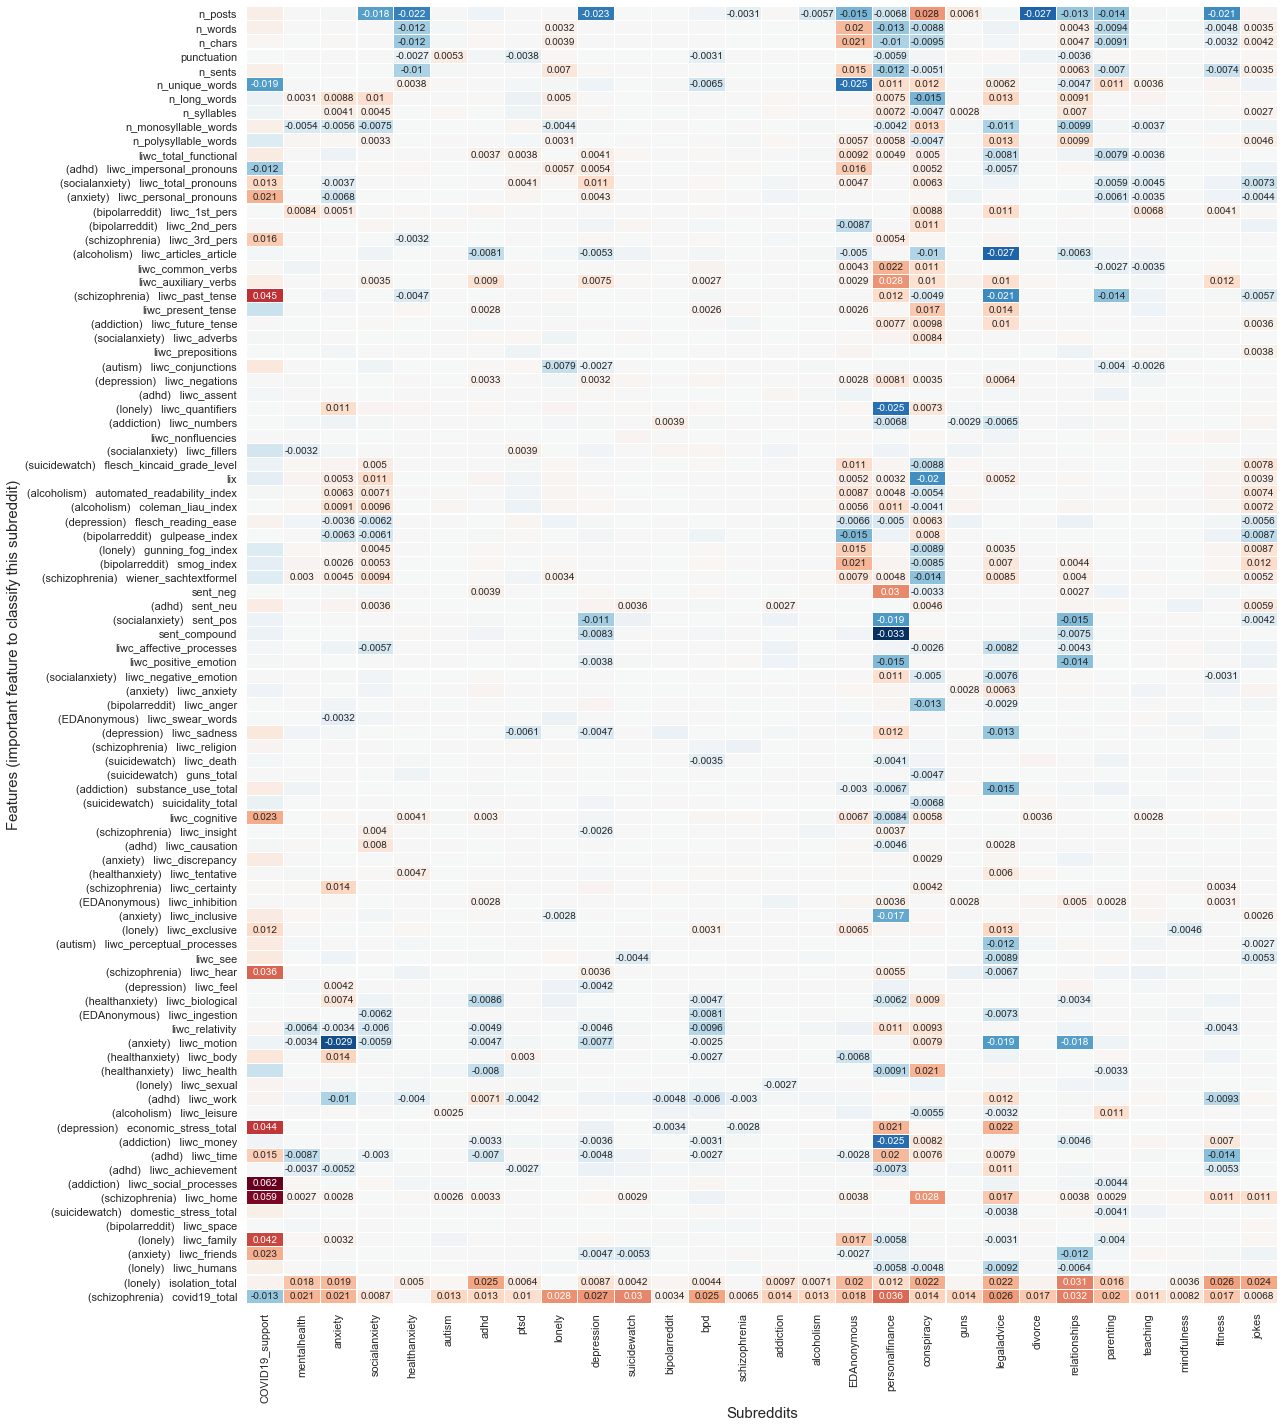

In [115]:
# Plot

plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'
plt.clf()
sns.set(style='white', rc={'figure.figsize':(18,20)}, font_scale =1)
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.1)
# Make sure 0 is white
divnorm = DivergingNorm(vmin=df_slope_r2.min().min(), vcenter=0, vmax=df_slope_r2.max().max())
sns.heatmap(df_slope_r2, norm=divnorm, cmap =cmap,cbar = False,linewidths=0)
ax = sns.heatmap(df_slope_r2, cmap=cmap,norm=divnorm, cbar = False,mask=reject_df, linewidths=0.1,
            annot=True,annot_kws={"fontsize":10})

# So it won't get cutoff
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


plt.ylabel('Features (important feature to classify this subreddit)',fontsize=15)
plt.xlabel('Subreddits', fontsize=15)
plt.tight_layout()
plt.savefig(f'./data/{plot_name}.png', dpi=400)

In [139]:
# Plot from 2019
pre_or_post = 'pre'
subreddits_2019 = subreddits.copy()
subreddits_2019.remove('COVID19_support')
df_slope_r2, reject_df = main_table(subreddits_2019, keep, timestep = 2,
                                    pre_or_post = pre_or_post, add_subreddits_to_features=True)



loading...
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
mindfulness
fitness
jokes
features before filtering:  (92, 27)
features after filtering:  (92, 27)
Significant results:  0.0012077294685990338


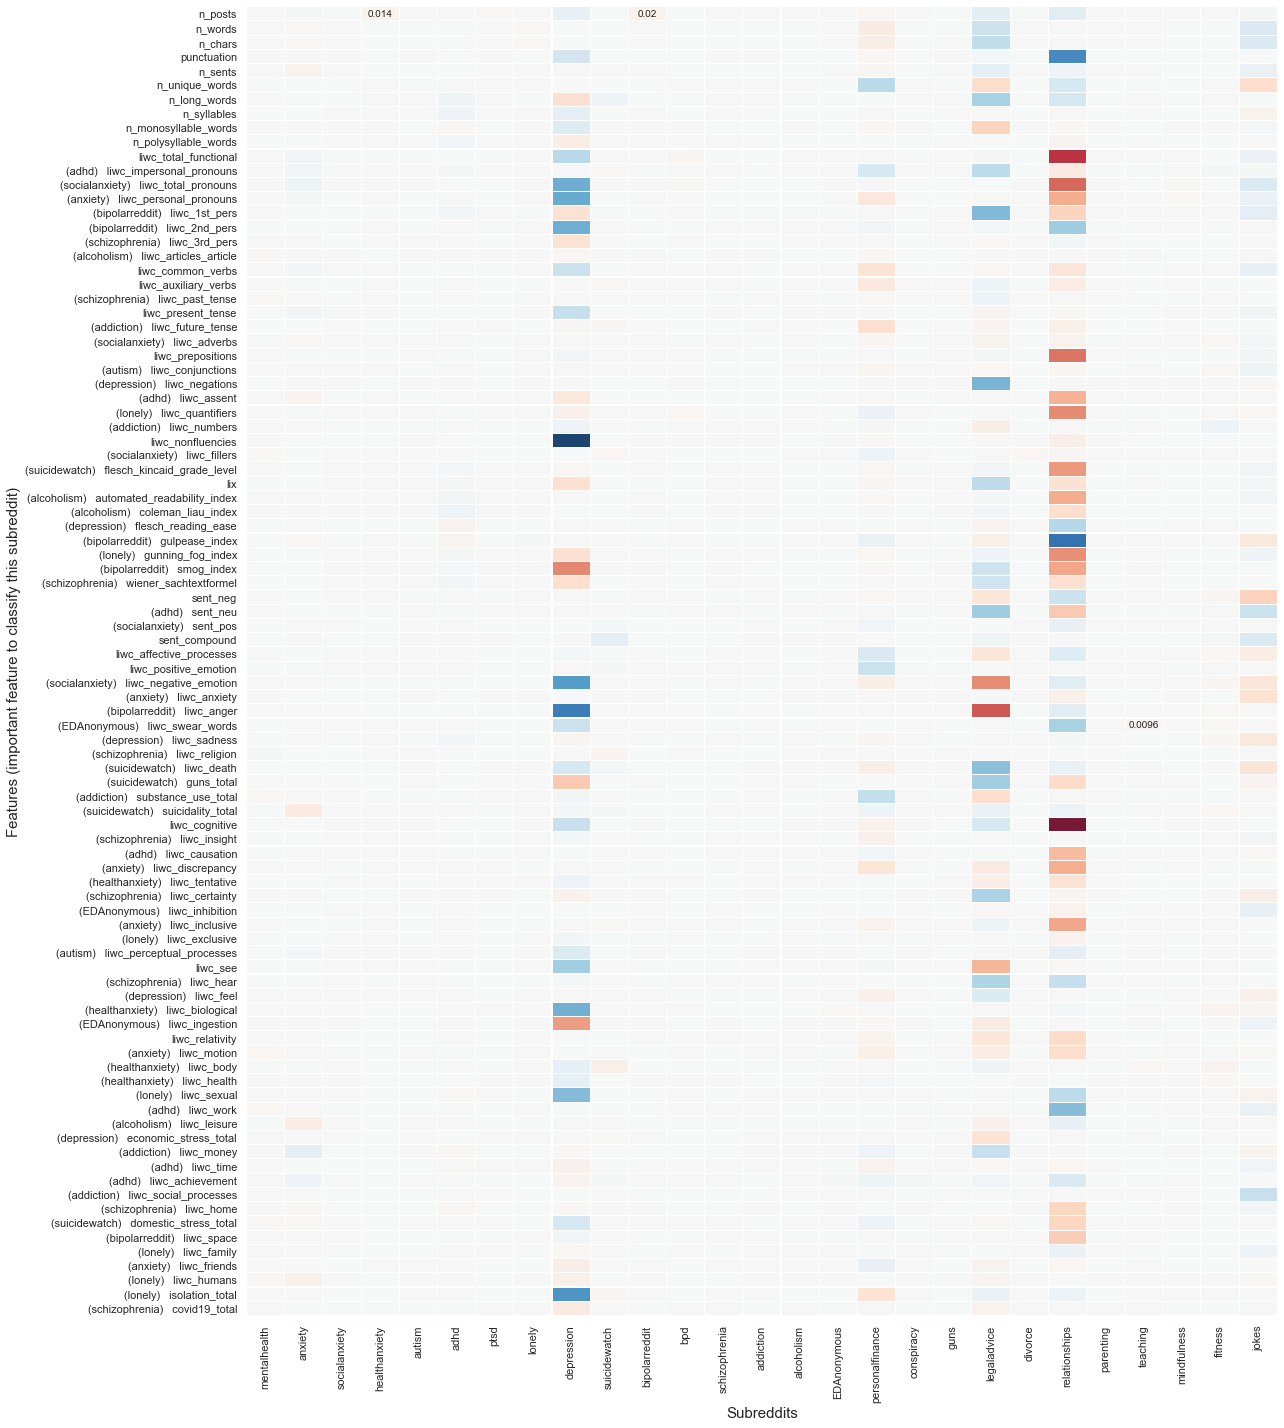

In [140]:
# Plot
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main_small_version'
mask = reject_df #reject_df or False

plt.clf()
sns.set(style='white', rc={'figure.figsize':(18,20)}, font_scale =1)
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.1)
# Make sure 0 is white
divnorm = DivergingNorm(vmin=df_slope_r2.min().min(), vcenter=0, vmax=df_slope_r2.max().max())
sns.heatmap(df_slope_r2, norm=divnorm, cmap =cmap,cbar = False,linewidths=0)
ax = sns.heatmap(df_slope_r2, cmap=cmap,norm=divnorm, cbar = False,mask=mask, linewidths=0.1,
            annot=True,annot_kws={"fontsize":10})

# So it won't get cutoff
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


plt.ylabel('Features (important feature to classify this subreddit)',fontsize=15)
plt.xlabel('Subreddits', fontsize=15)
plt.tight_layout()
plt.savefig(f'./data/{plot_name}.png', dpi=400)


=====sent_pos====


<Figure size 504x504 with 0 Axes>

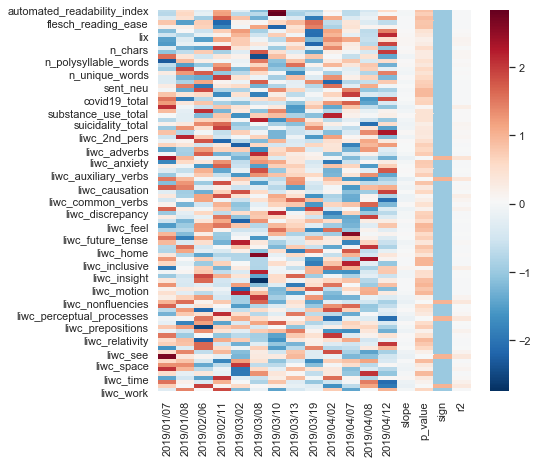

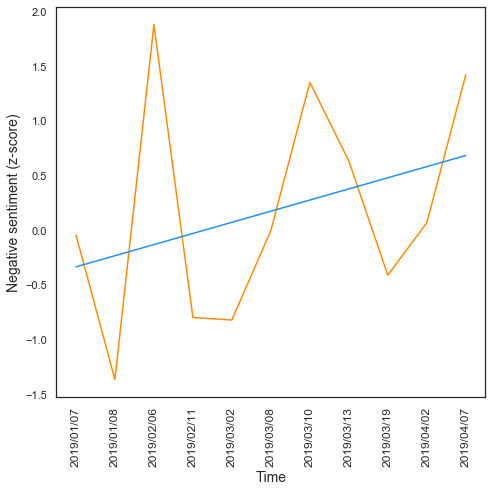

In [161]:
sns.set(style='white', rc={'figure.figsize':(7,7)}, font_scale =1)


# Why are slopes * r^2 so high but not significant? My guess is very non-linear or not enough posts?
subreddit = 'depression'
pre_or_post = 'pre'
filter_days = ['2018/']+ ['2019/04/'+str(n).zfill(2) for n in range(21,31) ]+['2019/'+str(n).zfill(2) for n in range(5,13) ]
# filter_days=False
summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = pre_or_post, 
                       timestep = 1, metric='mean',weigh_by_Nwords = True, filter_days = filter_days,zscore_slope=False)

# Plot
plt.clf()
plt.figure()
# sns.set(style='white', rc={'figure.figsize':(16,30)}, font_scale =1)
sns.heatmap(summary, cmap = 'RdBu_r')



plt.figure()
# sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
# for variable in keep:
for variable in ['sent_pos']:
    print('\n====={}===='.format(variable))
    x_name = summary.columns[:-6].values
    x_name = [n.replace('2020/','') for n in x_name]
    x = range(len(x_name))
    y = summary.T[variable][:-6].values
    plt.plot(x_name,y ,color='darkorange')
    plt.title('')
    plt.ylabel('Negative sentiment (z-score)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(np.arange(min(x), max(x)+1, 1),rotation=90, fontsize = 12)
#     plt.xticks(rotation=90)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='dodgerblue')
    plt.tight_layout()
#     plt.savefig('./data/trend_example_down_neg_sent.png', dpi=400)
    plt.show()





In [151]:
# found the problem: there's not enough samples in 2019
summary

,2019/01/07,2019/02/06,2019/03/02,2019/03/10,2019/03/19,2019/04/07,2019/04/12,slope,p_value,sign,r2
automated_readability_index,-0.188111,0.656523,-1.316491,1.552772,-0.611535,-1.049332,0.956175,0.025932,0.912071,-1,0.002690
coleman_liau_index,-0.109536,0.955855,-1.357370,1.773730,-0.533017,-0.882257,0.152596,-0.073767,0.752256,-1,0.021766
flesch_kincaid_grade_level,-0.050290,0.603443,-0.580258,-0.513911,-0.993201,-0.623785,2.158001,0.134195,0.560597,-1,0.072034
flesch_reading_ease,-0.545748,-1.246602,0.299452,1.586245,1.026765,0.095963,-1.216077,0.050052,0.830908,-1,0.010021
gulpease_index,0.451592,-1.223476,1.137291,-1.797761,0.656837,0.532062,0.243454,0.085936,0.712512,-1,0.029540
gunning_fog_index,-1.033740,-0.033148,0.096569,0.278737,-0.926751,-0.546358,2.164691,0.269484,0.211904,-1,0.290487
lix,-0.888409,-0.172772,0.088385,0.199249,-0.813138,-0.658103,2.244788,0.268836,0.213221,-1,0.289091
smog_index,-2.155320,-0.540921,0.718000,0.492398,0.033031,0.374554,1.078258,0.387383,0.040787,1,0.600261
wiener_sachtextformel,-1.156496,-0.098980,0.492772,0.017326,-0.908241,-0.441549,2.095168,0.273887,0.203059,-1,0.300057
n_chars,-1.211083,0.576469,0.388203,-0.049403,1.033062,0.993145,-1.730394,-0.002847,0.990333,-1,0.000032


In [ ]:
summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = pre_or_post, 
                       timestep = 2, metric='mean',weigh_by_Nwords = True, filter_days = filter_days,zscore_slope=False)


# Which mental health subreddits changed most?
Sum r^2 across features for each


In [299]:
top_effects_all = df_filtered[~reject_df].abs().sum().sort_values()[::-1].round(3)
top_effects_all = top_effects_all.reset_index()
top_effects_all.columns = ['subreddit', 'Σ |slope| x R^2\n all features']
top_effects_all


# Weigh negatively 'sent_compound', 'sent_pos','liwc_positive_emotion',

# Look at only negative features
features = [ 
    'sent_compound', 'sent_pos','liwc_positive_emotion', #weigh pos features * -1
    'sent_neg', 'economic_stress_total',
       'isolation_total', 'substance_use_total', 'guns_total',
       'domestic_stress_total', 'suicidality_total',  
'liwc_anger',
       'liwc_anxiety',  'liwc_death', 'liwc_negations',
       'liwc_negative_emotion','liwc_sadness', ]
df_filtered2 = df_filtered.T[features].T

for feature in ['sent_compound', 'sent_pos','liwc_positive_emotion']:
    df_filtered2.loc[feature] = df_filtered2.loc[feature] * -1


top_effects_emotional = df_filtered2[~reject_df].sum().sort_values()[::-1].round(3)
top_effects_emotional = top_effects_emotional.reset_index()
top_effects_emotional.columns = ['subreddit', 'Σ slope x R^2\n neg. emotional features']
top_effects_emotional


,subreddit,Σ slope x R^2 neg. emotional features
0,personalfinance,0.150
1,relationships,0.070
2,COVID19_support,0.044
3,adhd,0.032
4,depression,0.031
5,jokes,0.028
6,fitness,0.023
7,EDAnonymous,0.020
8,anxiety,0.019
9,mentalhealth,0.018


In [300]:
top_effects  = pd.concat([top_effects_all, top_effects_emotional], axis=1)
print(top_effects.to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
       subreddit &  Σ |slope| x R\textasciicircum 2\textbackslash n all features &        subreddit &  Σ slope x R\textasciicircum 2\textbackslash n neg. emotional features \\
\midrule
 personalfinance &                           0.565 &  personalfinance &                                    0.150 \\
      conspiracy &                           0.492 &    relationships &                                    0.070 \\
 COVID19\_support &                           0.454 &  COVID19\_support &                                    0.044 \\
     legaladvice &                           0.452 &             adhd &                                    0.032 \\
     EDAnonymous &                           0.342 &       depression &                                    0.031 \\
   relationships &                           0.247 &            jokes &                                    0.028 \\
         anxiety &                           0.217 &          fitness &               

## Select subset of table for presentation

In [92]:
subreddits

['addiction',
 'guns',
 'socialanxiety',
 'schizophrenia',
 'healthanxiety',
 'suicidewatch',
 'EDAnonymous',
 'mentalhealth',
 'COVID19_support',
 'teaching',
 'fitness',
 'personalfinance',
 'meditation',
 'bipolarreddit',
 'adhd',
 'conspiracy',
 'autism',
 'mentalillness',
 'alcoholism',
 'bpd',
 'ptsd',
 'divorce',
 'legaladvice',
 'jokes',
 'mindfulness',
 'anxiety',
 'depression',
 'parenting',
 'relationships',
 'lonely']

In [70]:

features4 = ['n_posts','n_words','sent_neg', 'sent_pos','economic_stress_total', 'isolation_total',
             'liwc_motion', 'liwc_home','liwc_body','liwc_past_tense',]

features4 = ['n_posts','n_words','sent_neg', 'sent_pos','economic_stress_total', 'isolation_total',
             'liwc_motion', 'liwc_home']

subreddits4 = [
     'COVID19_support',
 'anxiety',
     'socialanxiety',
     'healthanxiety',
     'depression',
 'suicidewatch',    
 'EDAnonymous',

 'personalfinance',
 'relationships',
 'guns',
]



In [76]:
features=keep.copy() #all features


# Filter subreddits
df_slope_filtered = df_slope[subreddits3]
df_p_value_filtered = df_p_value[subreddits3]
df_r2_filtered =df_r2[subreddits3]

# Filter features
df_slope_filtered = df_slope_filtered.T[features].T
df_p_value_filtered = df_p_value_filtered.T[features].T
df_r2_filtered = df_r2_filtered.T[features].T



# NEW r**2 multiple by the sign of the slope (1 or -1)
df_r2_signed = df_r2_filtered * df_slope_filtered

# OLD: # r**2 multiple by the sign of the slope (1 or -1)
# df_r2_signed = df_r2_filtered * ( df_slope_filtered/np.abs(df_slope_filtered))

# filter features
df_filtered = df_r2_signed.T[keep].T


In [77]:
df_filtered_shape = df_filtered.shape
df_filtered_shape

# Multiple comparison correction
pvals= df_p_value_filtered.values.flatten()
reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

# Create mask
reject_opp = np.array([not c for c in reject])
reject_df = pd.DataFrame(reject_opp.reshape(df_filtered_shape))
reject_df.columns = df_filtered.columns
reject_df.index = df_filtered.index


In [78]:
# filter subreddits
df_filtered4 = df_filtered[subreddits4]
reject_df4 = reject_df[subreddits4]

# filter features
df_filtered4 = df_filtered4.T[features4].T
reject_df4 = reject_df4.T[features4].T


In [79]:
new_index = df_filtered4.index
new_index = [n.replace('liwc_','').replace('_total','').replace('sent_', 'sentiment ').replace('_', ' ') for n in new_index]
# new_columns = [n.replace('liwc_','').replace('_total','').replace('sent_', 'sentiment ').replace('_', ' ') for n in new_index]

reject_df4.index = new_index
df_filtered4.index = new_index

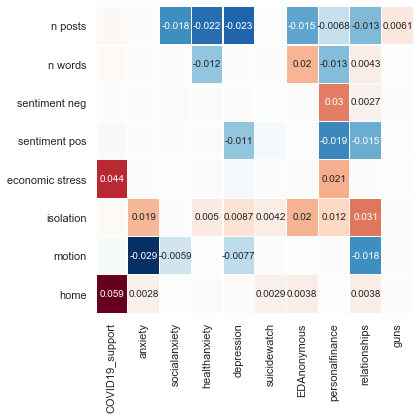

In [82]:
# Plot

sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.65)
plt.clf()
divnorm = DivergingNorm(vmin=df_filtered.min().min(), vcenter=0, vmax=df_filtered.max().max())
sns.heatmap(df_filtered4, norm=divnorm, cmap ="RdBu_r",cbar = False,linewidths=0.1)

# mask
ax = sns.heatmap(df_filtered4, cmap=cmap, norm=divnorm,  cbar = False,mask=reject_df4, linewidths=0.1,
            annot=True,annot_kws={"fontsize":10})


bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.title('R^2 * sign of the slope')
plt.tight_layout()
# plt.ylabel('Features (important feature to classify this subreddit)',fontsize=15)
# plt.xlabel('Subreddits', fontsize=15)

plt.savefig('./data/heatmap_r2_everything_bh_small_v2.png', dpi=400)

## Classification: measure amount of user repeats

In [ ]:
reddit_data = load_reddit.multiclass(input_dir, subreddits, pre_or_post = 'pre')

'''
# Check how many authors are in both train and test set

X = reddit_data.author.values
y = reddit_data.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


from collections import Counter
Counter(X)


unique_posts = len(np.unique(X))/len(X)

repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)


# 




In [1]:

def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2

In [6]:

def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):

    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # subsample_subreddits_overN = 25000 #subsample if dataset > N, set to 0 for all

    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder + 'feature_extraction/'+subreddits[0]+'_{}_features.csv'.format(pre_or_post), index_col=False)
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    # Concat tfidf features
    reddit_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[0]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
    reddit_data = reddit_data.merge(reddit_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",

    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    if subreddits[0]=='COVID19_support':
      reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]


    print(reddit_data.shape)
    # Subsample to int or subsample float

    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder + 'feature_extraction/'+subreddits[i]+'_{}_features.csv'.format(pre_or_post), index_col=False)
        new_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[i]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
        new_data = new_data.merge(new_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",
        if subreddits[i]=='COVID19_support':
          reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data


In [8]:
subreddits = ['addiction','EDAnonymous','adhd','autism','alcoholism', 'bipolarreddit', 'depression', 'anxiety','healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']
data_folder = './../../datum/reddit/input/'
subsample = 5600
reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = subsample,pre_or_post = 'pre')

(30122, 351)
(5600, 351)
===
addiction
(6406, 351)
(5600, 351)
===
adhd
(30095, 351)
(5600, 351)
===
alcoholism
(5654, 351)
(5600, 351)
===
anxiety
(30155, 351)
(5600, 351)
===
autism
(7860, 351)
(5600, 351)
===
bipolarreddit
(7252, 351)
(5600, 351)
===
depression
(30318, 351)
(5600, 351)
===
healthanxiety
(11640, 351)
(5600, 351)
===
lonely
(20638, 351)
(5600, 351)
===
schizophrenia
(12545, 351)
(5600, 351)
===
socialanxiety
(21782, 351)
(5600, 351)
===
suicidewatch
(30373, 351)
(5600, 351)


In [12]:
from sklearn.model_selection import train_test_split
from collections import Counter

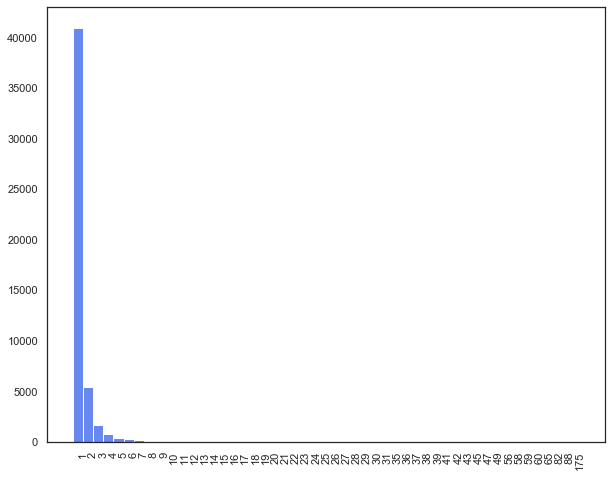

unique posts 0.6914148351648352


In [39]:
# Check how many authors are in both train and test set

X = reddit_data.author.values
y = reddit_data.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


repeated_posters = Counter(X).values()
histogram(Counter(X).values())

unique_posts = len(np.unique(X))/len(X)
print(f'unique posts {unique_posts}')





In [40]:
# The whole training set 
print(Counter(X).most_common()[:5])
top_poster0 = Counter(X).most_common()[0][0]
top_poster1 = Counter(X).most_common()[1][0]
print(top_poster0)
print([n[:50] for n in reddit_data[reddit_data.author==top_poster0].post.values[:10]])
print(reddit_data[reddit_data.author==top_poster0].subreddit.values[:30])
print([n[:50] for n in reddit_data[reddit_data.author==top_poster1].post.values[:10]])
print(reddit_data[reddit_data.author==top_poster1].subreddit.values[:30])


[('askaboutaa', 175), ('littymcwork', 88), ('jibberjabbery', 82), ('Rhys345', 65), ('EDAnonymous_Bot', 60)]
askaboutaa
['Grapevine Daily Quote April 5 "I  learned ... that', 'Grapevine Daily Quote January 31 "We   well know t', 'Grapevine Daily Quote January 1 "If  humility can ', 'Grapevine Daily Quote December 12 "Coincidences ar', 'Grapevine Daily Quote March 26 "As  AA grows, it i', 'Grapevine Daily Quote February 20 "In  the meeting', 'Grapevine Daily Quote March 28 "One  of the first ', 'Grapevine Daily Quote February 7 "Be willing to be', 'Grapevine Daily Quote March 29 "Until  I was at my', 'Grapevine Daily Quote January 4 "As I trudge the R']
['alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholi

## These are quotes need to be removed. Also would be interesting to see what characterizes people post a lot.  Or in which subreddits are there the most cases of top posters. Do people start posting a lot all of a sudden?


2019 is also from 2018 November?

In [44]:
repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)


In [43]:
print(f'repeated_proportion: {repeated_proportion}')

repeated_proportion: 0.4058379120879121


In [51]:
#If we remove top posters, then what is the repeated proportion
repeated_posters = [n for n in Counter(X).most_common() if n[1]>1]
print(f'amount of authors with > 1 post: {len(repeated_posters)/len(X)}')



amount of authors with > 1 post: 0.12847527472527473


In [60]:
# Remove posters > 1
print(reddit_data.shape)
reddit_data_drop_duplicates = reddit_data.drop_duplicates(subset='author', keep='first')
print(reddit_data_drop_duplicates.shape)
reddit_data_drop_duplicates.head()
reddit_data_drop_duplicates.groupby('subreddit').count()



(72800, 351)
(50335, 351)


,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,lix,...,tfidf_without,tfidf_wonder,tfidf_work,tfidf_world,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
subreddit,,,,,,,,,,,,,,,,,,,,,
EDAnonymous,2945,2945,2945,2945,2945,2945,2945,2945,2945,2945,...,2945,2945,2945,2945,2945,2945,2945,2945,2945,2945
addiction,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,...,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278
adhd,4693,4693,4693,4693,4693,4693,4693,4693,4693,4693,...,4693,4693,4693,4693,4693,4693,4693,4693,4693,4693
alcoholism,3981,3981,3981,3981,3981,3981,3981,3981,3981,3981,...,3981,3981,3981,3981,3981,3981,3981,3981,3981,3981
anxiety,4919,4919,4919,4919,4919,4919,4919,4919,4919,4919,...,4919,4919,4919,4919,4919,4919,4919,4919,4919,4919
autism,3854,3854,3854,3854,3854,3854,3854,3854,3854,3854,...,3854,3854,3854,3854,3854,3854,3854,3854,3854,3854
bipolarreddit,2501,2501,2501,2501,2501,2501,2501,2501,2501,2501,...,2501,2501,2501,2501,2501,2501,2501,2501,2501,2501
depression,4928,4928,4928,4928,4928,4928,4928,4928,4928,4928,...,4928,4928,4928,4928,4928,4928,4928,4928,4928,4928
healthanxiety,2708,2708,2708,2708,2708,2708,2708,2708,2708,2708,...,2708,2708,2708,2708,2708,2708,2708,2708,2708,2708


In [61]:

X = reddit_data_drop_duplicates.author.values
y = reddit_data_drop_duplicates.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


In [62]:
repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)
print(f'repeated_proportion: {repeated_proportion}')

repeated_proportion: 0.0


,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_without,tfidf_wonder,tfidf_work,tfidf_world,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
5524,EDAnonymous,030728,2018/11/21,Realized I have a crush on a co-worker ... So ...,2.593851,4.392563,4.022119,86.914259,76.152318,6.235558,...,0.000000,0.000000,0.132373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17181,EDAnonymous,yes_creamcheese,2019/10/18,How I know I'm disordered/PBJ Saga I've been c...,1.388732,3.935638,2.748830,90.178278,85.434109,5.809652,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6894,EDAnonymous,dramanautica,2019/04/27,"Scared I made my sister ED Hey guys, I’m prett...",0.753441,2.579243,2.714194,94.007957,81.903226,5.423656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23481,EDAnonymous,SowoneulMalhaebwaa,2019/01/14,Proof that ED makes you think absolutely insan...,4.269207,6.173943,4.917147,81.818512,71.832370,7.717424,...,0.000000,0.000000,0.103792,0.000000,0.000000,0.000000,0.102862,0.000000,0.000000,0.000000
14479,EDAnonymous,whatever171,2019/01/18,"I finally ate real healthily today! 1,200 calo...",1.525446,4.261267,2.817619,87.075000,91.291667,5.242857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19851,EDAnonymous,watchmedisapr,2018/12/21,Off topic: update on my post a week ago Link h...,1.086250,3.167833,2.441971,95.032000,82.184713,4.944108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114341
18032,EDAnonymous,throwawayacc19392,2018/12/31,"I am back with an ED... yay, I guess. I gained...",0.978333,2.692428,3.044222,92.473000,80.666667,6.542222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28479,EDAnonymous,HockeyPossum,2019/07/20,When you have to quit your job because the mer...,6.804536,5.299578,6.848197,82.180273,65.393443,9.444809,...,0.000000,0.000000,0.179570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6819,EDAnonymous,whatxever,2019/06/22,EDs + porn :/ navigating my first serious rela...,3.127957,5.295432,4.511442,82.335816,75.789474,7.826850,...,0.053515,0.000000,0.000000,0.000000,0.000000,0.000000,0.078949,0.000000,0.000000,0.075724
22223,EDAnonymous,llaannaa,2019/07/28,Slowly saving money and not having my ED make ...,3.811317,3.760260,6.214064,79.404376,71.123288,9.091629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076457


## Are amount of days uniform?

In [436]:

count = dict(Counter(reddit_data.date.values))

count2 = pd.DataFrame(count, index=[0])
count2 = count2.T.reset_index()
count2.columns = ['date', 'count']
count2 = count2.sort_values('date')

# filter days
days= count2.date.values

days = [n for n in days if 
       '/2019/01' in n or
       '/2019/02' in n or
       '/2019/03' in n or
       '/2019/04' in n]
count2 = count2[count2.date.isin(days)]
count2
plt.bar(x=count2.date,height=count2['count'])
plt.xticks(ticks = list(count2.date)[::10],rotation=90,fontsize=10)
plt.show()

,date,count


In [437]:
pre_or_post = 'post'
days = []
for sr in subreddits_mental_health:
    df = pd.read_csv(input_dir+'feature_extraction/{}_{}_features.csv'.format(subreddit,pre_or_post))
    days.append(df.date.values)
    

In [440]:
days[0]

array(['2020/01/01', '2020/01/01', '2020/01/01', ..., '2020/04/20',
       '2020/04/20', '2020/04/20'], dtype=object)

In [442]:
days2 = [n for i in days for n in i]
Counter(days2)

Counter({'2020/01/01': 4342,
         '2020/01/02': 7241,
         '2020/01/03': 6591,
         '2020/01/04': 4953,
         '2020/01/05': 4797,
         '2020/01/06': 6942,
         '2020/01/07': 6851,
         '2020/01/08': 7111,
         '2020/01/09': 6890,
         '2020/01/10': 7189,
         '2020/01/11': 5291,
         '2020/01/12': 5070,
         '2020/01/13': 6448,
         '2020/01/14': 7761,
         '2020/01/15': 7007,
         '2020/01/16': 7137,
         '2020/01/17': 7098,
         '2020/01/18': 5473,
         '2020/01/19': 5395,
         '2020/01/20': 6188,
         '2020/01/21': 6877,
         '2020/01/22': 7761,
         '2020/01/23': 7826,
         '2020/01/24': 6890,
         '2020/01/25': 6071,
         '2020/01/26': 5486,
         '2020/01/27': 7020,
         '2020/01/28': 7293,
         '2020/01/29': 7579,
         '2020/01/30': 7397,
         '2020/01/31': 6747,
         '2020/02/01': 6435,
         '2020/02/02': 5395,
         '2020/02/03': 6500,
         '2020

## CHECK!

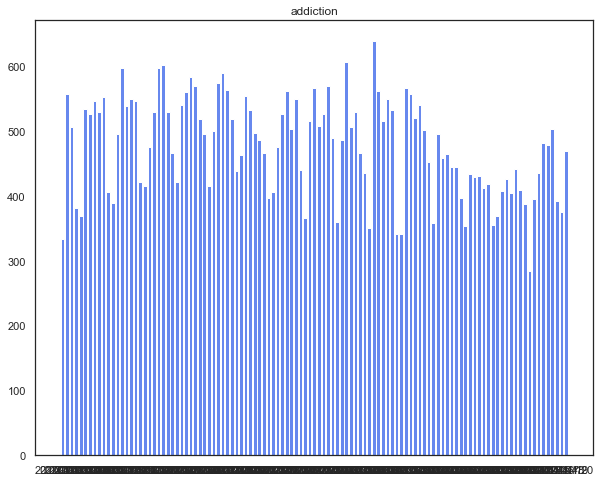

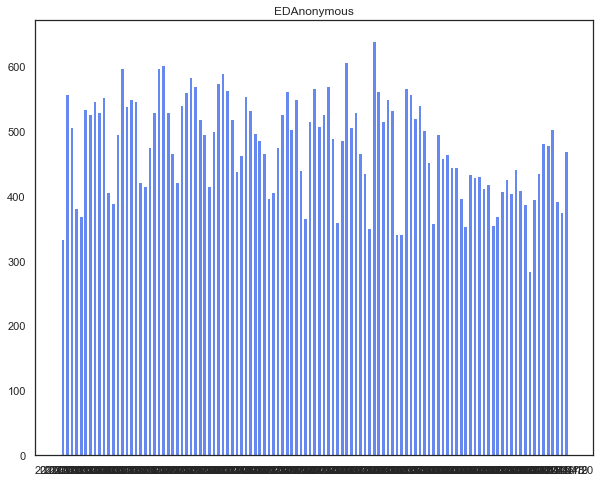

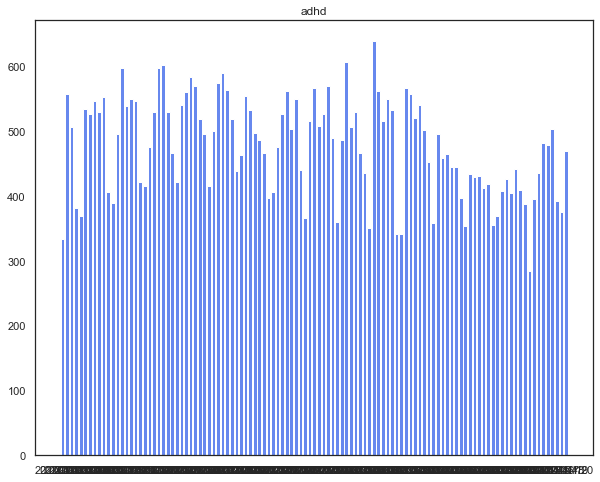

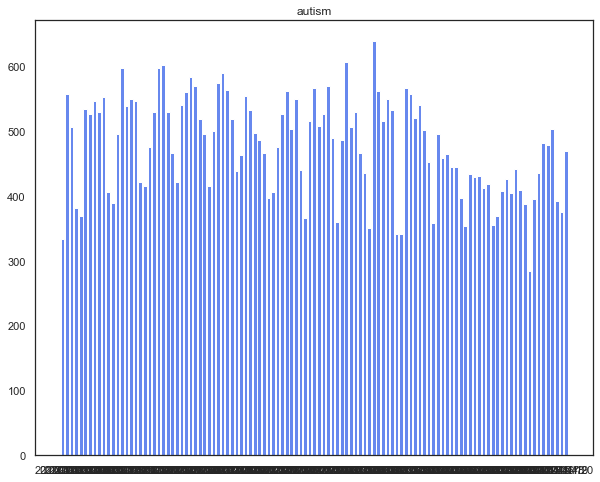

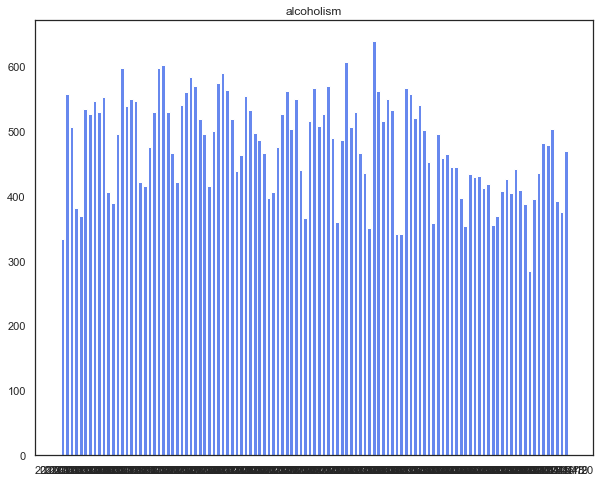

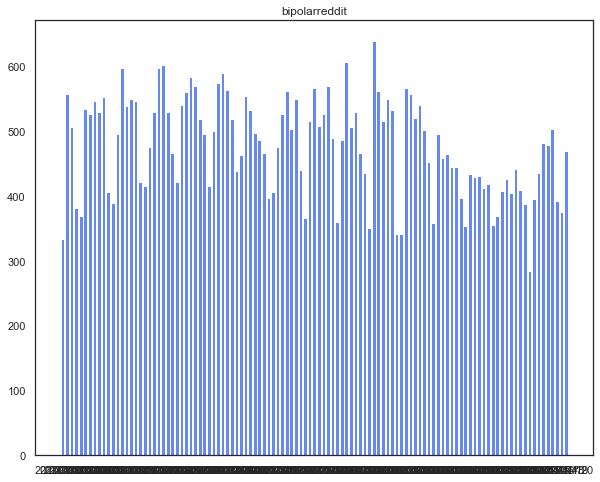

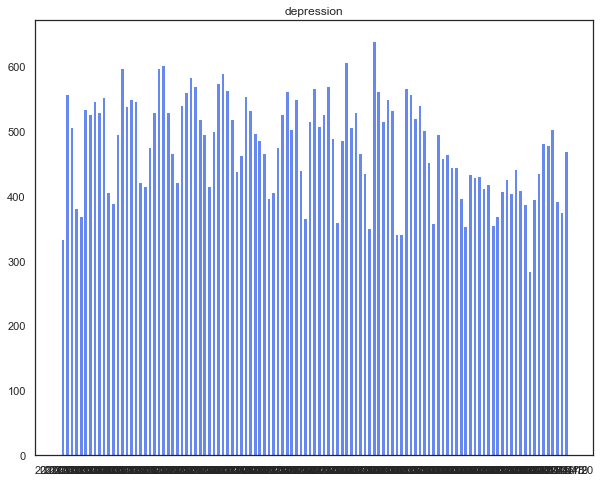

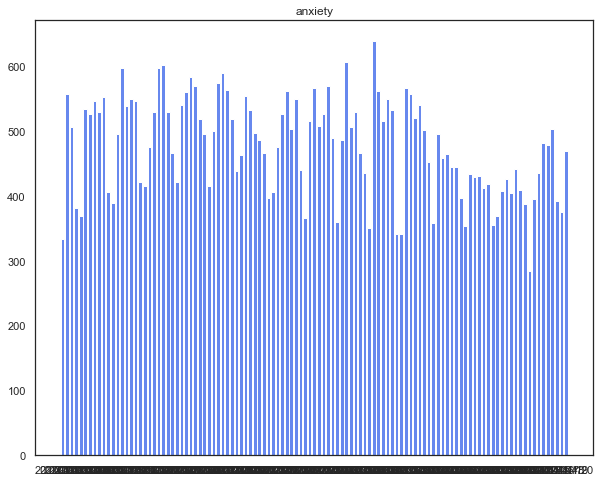

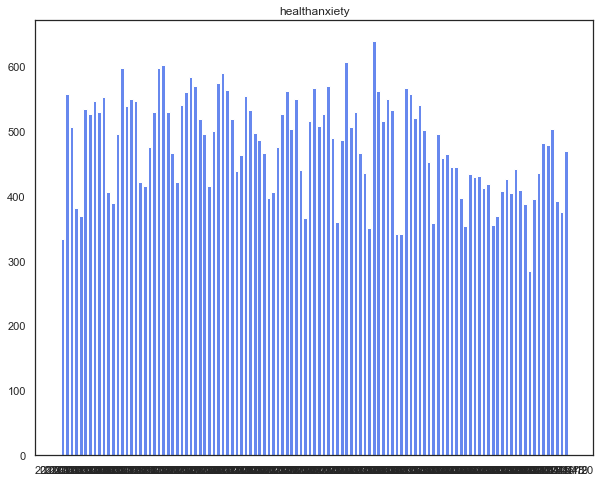

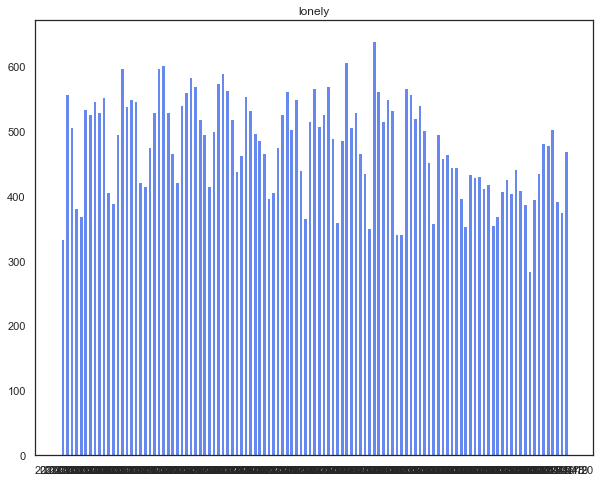

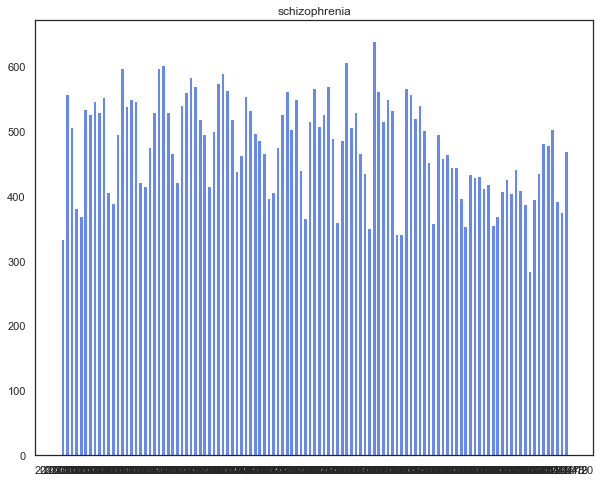

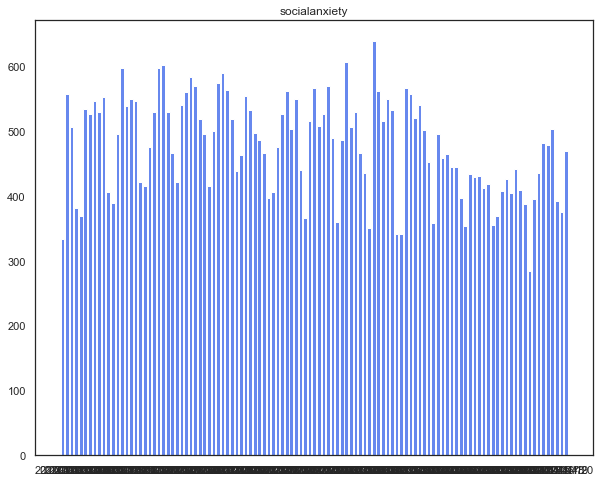

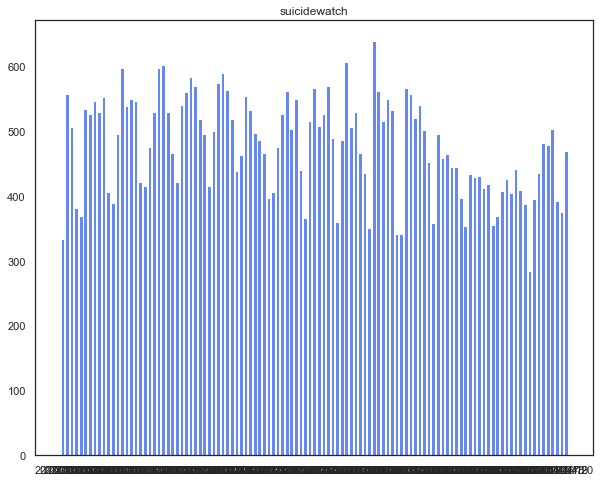

In [450]:
for d,sr in zip(days, subreddits_mental_health):
    counter = Counter(d)
    plt.figure()
    plt.title(sr)
    plt.bar(counter.keys(),height=counter.values())
    plt.show()



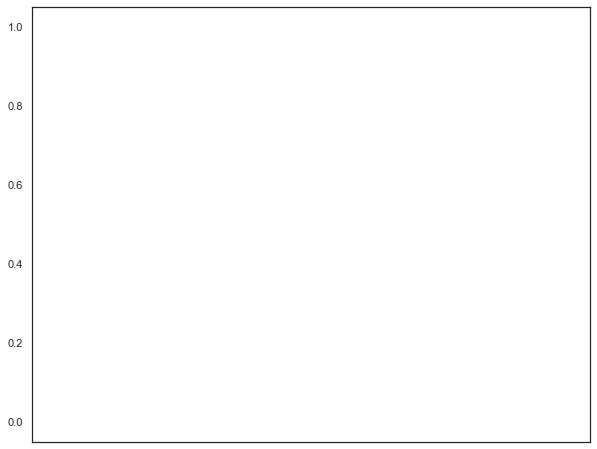

In [248]:
output_dir = './../../datum/reddit/input/'

In [249]:
df = pd.read_csv(output_dir+'features_depression_0.csv')
df.shape

(20980, 14)

In [250]:
# Search reddit
# Search unix code https://www.unixtimestamp.com/index.php
# Timeline: https://www.nytimes.com/article/coronavirus-timeline.html


In [251]:
# Anxiety corona virus
# JAN. 20 Other countries, including the United States, confirmed cases.
"I know this may sound silly, but I\u2019m scared of the coronavirus. A lot of people are saying it\u2019s not a big deal and that I\u2019ll be safe as long as I\u2019m healthy. I know all of this but I\u2019m more scared of the fact that this will turn into a pandemic."

# Other days:
# JAN. 30 The W.H.O. declared a global health emergency
# The World Health Organization on Feb. 11 proposed an official name for the disease the virus coronavirus causes: Covid-19
# Feb 23 Italy sees major surge in coronavirus cases and officials lock down towns.
subreddit = 'healthanxiety'
date_start = '2020/03/24'
date_end = '2020/03/30'

start = date2timestamp(date_start)
end = date2timestamp(date_end)
size = 1000000000
url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
print(url)
# filename = 'scrape_reddit'
# filename = filename+'_{}_{}'.format(date_start.replace('/', ''), date_end.replace('/', ''))


# Comment so it won't download

# url2json(url, output_dir+filename)
# anxiety_covid = json2list(output_dir+filename+'.json')

NameError: name 'date2timestamp' is not defined

In [252]:
timestamp2date(1579395379)

NameError: name 'timestamp2date' is not defined

In [253]:
def scrape_reddit(output_dir, subreddit, timeframe, date_start, date_end, size = 1000):
    '''
    size = {1,1000} #amount of posts
    '''
    start = date2timestamp(date_start)
    end = date2timestamp(date_end)
    url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
    filename = '{}_{}_{}_{}'.format(subreddit, timeframe, date_start.replace('/', ''), date_end.replace('/', ''))
    url2json(url, output_dir+filename)
    posts = json2list(output_dir+filename+'.json')
    posts_filtered = []
    for post in posts:
        post_filtered = {}
        for key in post.keys():
            post_filtered[key]=post.get(key)
        posts_filtered.append(post_filtered)
    # np.savez_compressed(input_dir+filename+'.npz',posts_filtered)
#     os.remove(output_dir+filename+'.json')
    return filename
        


In [254]:
date2timestamp(date_start)

NameError: name 'date2timestamp' is not defined

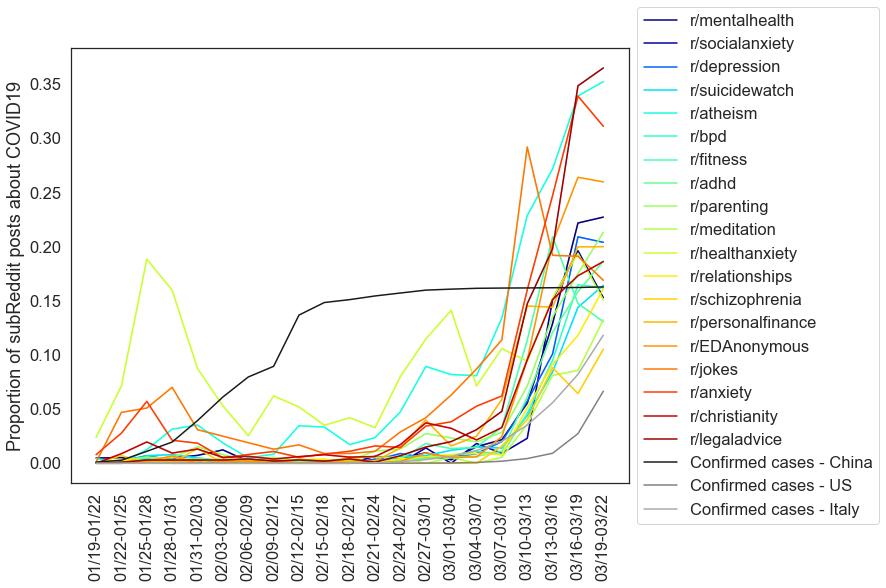

In [262]:
# subredditsx = ['anxiety', 'healthanxiety']
plot_across_time(subreddits,y_col = 'covid_boolean', y_col_div_by = 'total_posts',
                  ylabel='Proportion of subReddit posts about COVID19',filter_small = True, small_value = 150, 
                  plot_raw = True,  plot_line = False, alpha = 0.3, plot_covid_curves = True, zscore = False)



In [263]:
### Hypochondriac symptoms predict overall concern 1.5 months before. 
### All of Reddit converges on the same topic

In [264]:
'''
# Early:
01/19: {'created_utc': 1579618862, 'num_comments': 7, 'title': 'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?', 'selftext': 'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!', 'score': 1},
01/19: {'created_utc': 1579543321, 'num_comments': 1, 'title': 'Wuhan Virus anxiety', 'selftext': "Right off the bat, i'm not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by medical personal in hazmat suits. With the article spewing the whole sensationalized clickbait crap about an apocalyptic global epidemic.  \n\n\nAnd after seeing it i quickly spiraled into stress and anxiety. Even though i was able to avoid a full on panic attack, this article bothered me to the point that ll i've been thinking about is an outbreak for the rest of the day just by reading a news article for a few minutes.  \n\n\nI hope everybody in the east can stay safe and healthy, the worst i've had today is nearly having a panic attack. Can't imagine how worrying it is over there.", 'score': 1},
01/25: {'created_utc': 1580175419, 'num_comments': 3, 'title': 'so so so scared', 'selftext': 'this corona virus has me absolutely terrified. i know there\'s all these "low mortality" things, but i read to far into the conspiracies and the videos of chinese hospitals and doctors crying for help. \n\nive washed and sanitized my hands to the point they\'re cracked and bleeding. i won\'t leave the house anymore unless its 100% necessary.and even when i do i don\'t touch ANYTHING\n\nim so scared, breaking down crying, i can\'t even eat anymore. nothing the news or cdc says can calm me down because i am fully convinced china is lying and that this could even be a bioweapon. i heard it\'s mutated already and 300,000-1,000,000 people fled china possibly infected. i feel doomed'}



# Suicidality
03/16:        {'created_utc': 1584584727, 'num_comments': 0, 'title': 'I feel like a scared child but I have no parents to run to for safety', 'selftext': "I'm far from being actually alone, I don't even live alone, yet right now with the virus, the economic status, and the high stress everyone is feeling is making me feel like my bones are trying to crawl out of my flesh. I want it to stop, I want to scream and cry, I want to hide and honestly just fucking die so I don't have to live with any of these feelings anymore. I work minimum wage, I'm saving for the house I'm renting in May, but if I lose my job or can't work because of Covid-19 I am absolutely fucked. I am terrified and I feel pinned down by this overwhelming feeling it's all going to get so so much worse...Part of me wishes the world would just end. No worried then. No stress. I'm dreading my state saying we must stay home because my father is bipolar and refuses to go to therapy or get medication so I don't feel safe outside of my room and most of my social interactions outside of work come in arguments with him because he can never be wrong. He has to be right. I wish it would all just freeze or disappear.", 'score': 1},
# Works at hospital
03/16:        {'created_utc': 1584581971, 'num_comments': 0, 'title': 'Feeling overwhelmed about corona and working at the hospital', 'selftext': "I live in New York and work in a hospital. We were short on supplies even before the virus really became a thing here. We don't have masks to give patients. We are not allowed to wear masks ourself. We have been mandated to work and even been told to continue coming to work even if we have had contact with a confirmed positive. We just have to take our temperature daily &amp; we are only to wear a mask if we have active respiratory symptoms.\n\nI have constant shortness of breath and chest pains and pressure due to anxiety which has me constantly stressed. My throat is super dry and idk why. Dry throat and stress leaves you more susceptible to infection in addition to working in a war zone with no protection daily.\n\nI feel so anxious and overwhelmed. I was finally getting my panic attacks sorta under control by going out mor and starting therapy. That's all on hold for the indefinite future. Im constantly afraid of having another panic attack or being in the position where I feel like I'm actually dying and unable to see a provider due to the system being overwhelmed.\n\nThe only positive thing I have going on right now is that its about to be spring and I can garden while social distancing.", 'score': 1},
# Buying guns
03/16:        {'created_utc': 1584581413, 'num_comments': 24, 'title': 'Are we going to all die and go into an apocalypse? The media is starting to freak me out because of the Corona Virus', 'selftext': "I keep on seeing the Corona Virus everywhere now I hear people are buying guns then people are talking about Germany and how bad it is there. I thought that America was handling it very well. And we are on top of it? I'm freaking out. Am I overthinking between all the youtube posts I'm buggin.", 'score': 0},

03/16:        {'created_utc': 1584574890, 'num_comments': 1, 'title': 'My mom is driving herself crazy because of the COVID-19', 'selftext': 'My mom never have suffer from anxiety or other mental illness like OCD, etc. \nSince the COVID-19, we steam and sanitize our house all the day with the steamer machine, we use other product like Clorox or Javex, if she touches something in the house she wash her hand, I suffer from anxiety and it doesn’t help at all! I feel stress will kill our brain before the COVID-19, I’m tired, really tired, I want just this stupid virus to end and to go out. All we do is talking about this virus, the media is not helping at all... my head is gonna explode.', 'score': 3},
# GAD + Isolation  
      {'created_utc': 1584570369, 'num_comments': 0, 'title': 'Being single and living alone is absolutely brutal right now.', 'selftext': 'I live with generalized anxiety disorder and already have major anxiety regarding my health. Had the flu end of January pretty bad and then hives post flu- I’m miserable and was finally getting back on track and then this.\n\n\nI am terrified. Just being alone all day. And can’t see my parents or friends. Or brother. I have been so anxious through all of this for many reasons. \n\nfinally got the work from home okay on Monday but now being told by higher ups where I work (a health science college at a major uni) that someone needs to be in my office during the day, though it’s not essential. I hate the idea of going to my office which is connected to the main hospital in my city.\n\nAnyway. I really could use some people to talk to as I don’t have that many friends and that’s what I need now. I need some more connections and chances to get to other people and distract from the virus.\n\nThanks', 'score': 0},

'''

'\n# Early:\n01/19: {\'created_utc\': 1579618862, \'num_comments\': 7, \'title\': \'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?\', \'selftext\': \'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!\', \'score\': 1},\n01/19: {\'created_utc\': 1579543321, \'num_comments\': 1, \'title\': \'Wuhan Virus anxiety\', \'selftext\': "Right off the bat, i\'m not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by

In [265]:
subreddits2 = ['relationships','mindfulness', 'healthanxiety', 'anxiety', 'suicidewatch', 'depression', 'ptsd', 'adhd', 
              'bpd', 'paranoia', 'socialanxiety', 'schizophrenia', 'bipolarreddit', 'alcoholism', 'addiction',]







### Social anxiety: less posts, more words on average per post

In [94]:


plot_across_time('depression', y_col = 'sent_pos', y_col_div_by = False, zscore = False, 
                 ylabel='Positive sentiment',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.5, plot_covid_curves = False)

NameError: name 'output_dir' is not defined

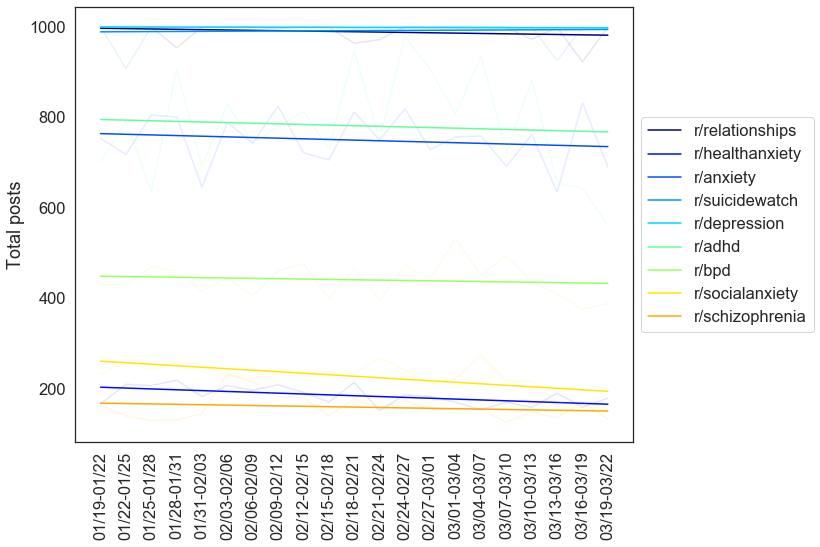

In [266]:
plot_across_time(subreddits2, y_col = 'total_posts', y_col_div_by = False, zscore = False, 
                 ylabel='Total posts',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)

In [0]:
plot_across_time(subreddits2, y_col = 'total_posts', y_col_div_by = False, zscore = True, 
                 ylabel='Total posts',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)


In [0]:
plot_across_time(subreddits2, y_col = 'all_words', y_col_div_by = 'total_posts', 
                 ylabel='Average words per post',
                 small_value = 150, plot_raw = True, zscore = True,
                     plot_line = True, alpha = 0.3, plot_covid_curves = False)

# Sentiment analysis: social anxiety getting less negative!

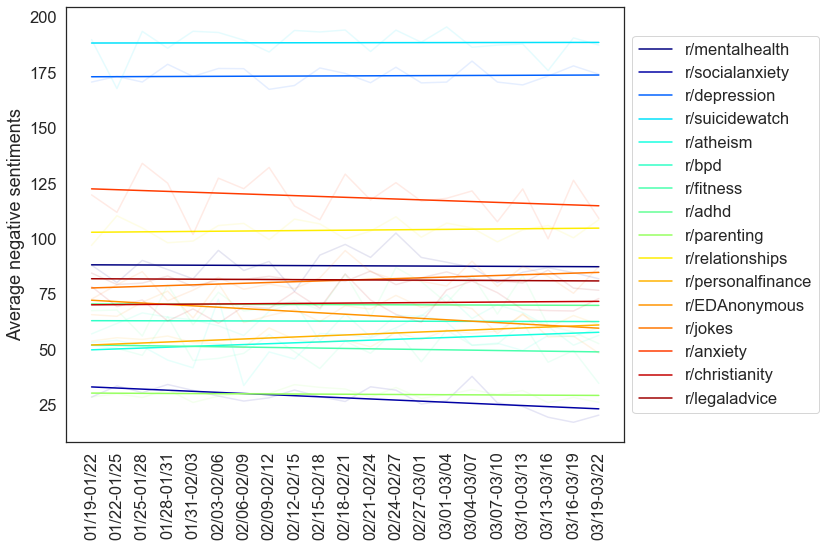

In [268]:
plot_across_time(subreddits, y_col = 'sent_neg', y_col_div_by = False, 
                 ylabel='Average negative sentiments',zscore = False,
                 filter_small = True, small_value = 200, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)


In [0]:

# input y variable across time



In [0]:
subreddit = 'socialanxiety'
y_col = 'sent_neg'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))

# Load data
xs = list(set(df_subreddit.date.values))
try: xs.remove(np.nan)
except: pass
xs.sort()
ys = []
cs = []
for day in xs:
    df_subreddit_day = df_subreddit[df_subreddit.date == day]
    y = df_subreddit_day[y_col].values
    ys.append(y)
    median_value = int(np.median(y))
    median_max = np.percentile(y,90)
    color = median_max*10**2
    color = np.max(y)*10**2
    cs.append('hsl({}%,50%,50%)'.format(color))


# plot
fig = go.Figure(data=[go.Box(
    y=ys[i],
    marker_color=cs[i],
    name = xs[i],
    ) for i in range(len(xs))])

# format the layout
fig.layout.update(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=True,   ticktext = xs),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
    showlegend=False,
    title=y_col+' as COVID-19 grows'
)

fig.show()

In [0]:
subreddit = 'socialanxiety'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="suicide_bool",hover_name='posts',
                 title=subreddit)

fig.show()

### Suicidality

In [0]:
subreddit = 'suicidewatch'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="sent_neg",hover_name='posts',
                 title="Numeric 'size' values mean continous color")

fig.show()

In [0]:
subreddit = 'suicidewatch'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="covid_boolean",hover_name='posts',
                 title=subreddit+' with COVID-19 related posts in yellow')

fig.show()

In [0]:
subreddit = 'socialanxiety'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="suicide_bool",hover_name='posts',
                 title=subreddit+' with suicidal related posts in yellow')

fig.show()




In [0]:
# The fact that it may be affecting ED more or certain disorders more could be useful
# How personal finance may be connected to mental could be studied: If personal finance become more similar to some disorder (tfidf))
# Target at risk people who post regularly and stopped posting? 



# TFIDF

In [0]:
# reload(extract_features)

In [0]:
# Create a corpus to build the matrix
posts_all = []
for sr in subreddits2:
    df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(sr))
    posts = df_subreddit.posts.values
    posts_all.append(posts)
    

corpus = [n for i in posts_all for n in i]
# remove nan
corpus = [n for n in corpus if isinstance(n,str)]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,3), stop_words='english',
                        max_features=512, min_df=2, max_df=0.8)



# Build matrix
vectorizer.fit_transform(corpus)

In [0]:
# Comment so it won't run



In [0]:
feature_array = np.array(vectorizer.get_feature_names())
n = 15

split = 0.9



for sr in subreddits2:
    df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(sr))
    posts = df_subreddit.posts.values
    posts = [n for n in posts if isinstance(n,str)]
    split_i = int(len(posts)*split)
    posts_before = posts[:split_i]
    posts_after = posts[split_i:]
    posts2 = [posts_before, posts_after]
    posts_names = ['before', 'after']
    for i in range(2):
        response = vectorizer.transform(posts2[i])
        tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
        top_n = feature_array[tfidf_sorting][:n]
        print('\n====={}==={}'.format(sr, posts_names[i]))
        print(top_n)
    print('\n\n===============')

In [0]:
# # Alternative method
# def tfidf(X_train_sentences = posts, lower_case = True, ngram_range = (1,3), max_features=512, min_df=2, max_df=0.8, model = 'svm'):
#     sw = stopwords.words('english')
#     vectorizer = TfidfVectorizer(lowercase=lower_case, ngram_range=ngram_range, stop_words=sw,max_features=max_features, min_df=min_df, max_df=max_df)
#     train_vectors = vectorizer.fit_transform(X_train_sentences).toarray()
#     feature_names = vectorizer.get_feature_names()
#     feature_names = ['tfidf_'+n for n in feature_names]
#     return train_vectors, feature_names
    
# X_test_sentences = False
# vectors, feature_names = tfidf(X_train_sentences = posts_all_days, lower_case = True, ngram_range = (1,3), max_features=512, min_df=2, max_df=0.8, model = 'svm')
    